<a href="https://colab.research.google.com/github/Rakshithts/myprojects/blob/main/air_quality_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages(c("tidyverse", "caret", "randomForest", "rpart", "rpart.plot", "class"))
install.packages(c("e1071", "xgboost"))
install.packages(c("ggplot2","ggpubr"))


In [ ]:
install.packages("caret", dependencies=TRUE)


In [ ]:
# Load required libraries
library(tidyverse)
library(caret)
library(randomForest)
library(rpart)
library(rpart.plot)
library(class)
library(e1071)
library(xgboost)
library(ggplot2)
library(ggpubr)

# Load dataset
data <- read.csv("/content/AirQualityUCI_Cleaned.csv")

# Convert Date and Time columns to datetime format
data$Datetime <- as.POSIXct(paste(data$Date, data$Time), format="%d/%m/%Y %H.%M.%S")

# Drop original Date and Time columns
data <- data %>% select(-Date, -Time)

# Handle missing values (impute with median)
# Convert all columns except 'Datetime' to numeric
num_cols <- setdiff(names(data), "Datetime")
data[num_cols] <- lapply(data[num_cols], function(x) as.numeric(as.character(x)))

# Impute missing values with column-wise median
for (col in num_cols) {
  data[[col]][is.na(data[[col]])] <- median(data[[col]], na.rm = TRUE)
}

# Split into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(data$C6H6.GT., p = 0.8, list = FALSE)
trainData <- data[trainIndex, ]
testData <- data[-trainIndex, ]

In [ ]:
# ---- Random Forest Model -----------------------------------------------------------
rf_model <- randomForest(C6H6.GT. ~ ., data = trainData, ntree = 100)
rf_pred <- predict(rf_model, testData)
rf_rmse <- sqrt(mean((rf_pred - testData$C6H6.GT.)^2))
cat("Random Forest RMSE:", rf_rmse, "\n")


Random Forest RMSE: 0.9998929 


Decision Tree RMSE: 1.432861 


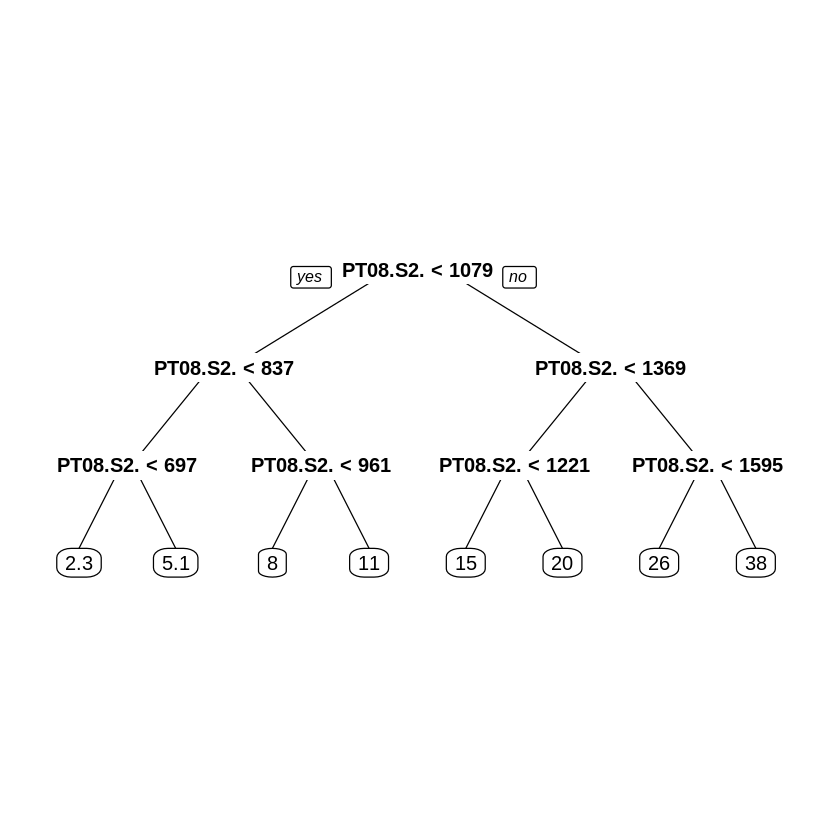

In [ ]:
# ---- Decision Tree Model --------------------------------------------------------
dt_model <- rpart(C6H6.GT. ~ ., data = trainData, method = "anova")
prp(dt_model) # Plot decision tree
dt_pred <- predict(dt_model, testData)
dt_rmse <- sqrt(mean((dt_pred - testData$C6H6.GT.)^2))
cat("Decision Tree RMSE:", dt_rmse, "\n")

In [ ]:
#--------------------------KNN-----------------------------------------------------------
# Ensure all predictors are numeric
trainData <- trainData %>% mutate(across(where(is.character), as.numeric))
testData <- testData %>% mutate(across(where(is.character), as.numeric))

# Handle missing values
trainData[is.na(trainData)] <- apply(trainData, 2, function(x) median(x, na.rm = TRUE))
testData[is.na(testData)] <- apply(testData, 2, function(x) median(x, na.rm = TRUE))

# Normalize the data
normalize <- function(x) { (x - min(x)) / (max(x) - min(x)) }
scaled_features <- as.data.frame(lapply(data[num_cols], normalize))

trainData_scaled <- scaled_features[trainIndex, ]
testData_scaled <- scaled_features[-trainIndex, ]

# Convert target variable to factor (only if classification)
train_labels <- as.factor(trainData$C6H6.GT.)
test_labels <- as.factor(testData$C6H6.GT.)

# Apply KNN
knn_pred <- knn(train = trainData_scaled, test = testData_scaled, cl = train_labels, k = 5)

# Compute RMSE and Accuracy
knn_rmse <- sqrt(mean((as.numeric(knn_pred) - as.numeric(test_labels))^2))
knn_accuracy <- 100 * (1 - (knn_rmse / mean(as.numeric(test_labels))))
cat("KNN - RMSE:", knn_rmse, "Accuracy:", knn_accuracy, "%\n")
cat("KNN RMSE:", knn_rmse, "\n")


KNN - RMSE: 15.34326 Accuracy: 84.37515 %
KNN RMSE: 15.34326 


In [ ]:
# ---- SVM Model --------------------------------------------------------
svm_model <- svm(C6H6.GT. ~ ., data = trainData, kernel = "radial")
svm_pred <- predict(svm_model, testData)
svm_rmse <- sqrt(mean((svm_pred - testData$C6H6.GT.)^2))
cat("SVM RMSE:", svm_rmse, "\n")
svm_accuracy <- sum(round(svm_pred) == testData$C6H6.GT.) / length(testData$C6H6.GT.) * 100
cat("SVM Accuracy:", svm_accuracy, "%\n")

SVM RMSE: 1.002334 
SVM Accuracy: 8.542068 %


In [ ]:
# ---- XGBoost Model ----
dtrain <- xgb.DMatrix(data = as.matrix(trainData[num_cols]), label = trainData$C6H6.GT.)
dtest <- xgb.DMatrix(data = as.matrix(testData[num_cols]), label = testData$C6H6.GT.)
xgb_model <- xgboost(data = dtrain, nrounds = 100, objective = "reg:squarederror")
xgb_pred <- predict(xgb_model, dtest)
xgb_rmse <- sqrt(mean((xgb_pred - testData$C6H6.GT.)^2))
cat("XGBoost RMSE:", xgb_rmse, "\n")
# Calculate XGBoost Accuracy
xgb_accuracy <- 100 * (1 - (xgb_rmse / mean(testData$C6H6.GT.)))
cat("XGBoost RMSE:", xgb_rmse, "\n")
cat("XGBoost Accuracy:", xgb_accuracy, "%\n")

In [ ]:
#----- accuracy aclculation --------------------------------------

# Function to Calculate Accuracy from RMSE
calculate_accuracy <- function(actual, predicted) {
  rmse <- sqrt(mean((actual - predicted)^2))  # Compute RMSE
  mean_actual <- mean(actual)  # Mean of actual values
  accuracy <- 100 * (1 - (rmse / mean_actual))  # Accuracy in percentage
  return(list(rmse = rmse, accuracy = accuracy))
}
# Random Forest Model
rf_model <- randomForest(C6H6.GT. ~ ., data = trainData, ntree = 100)
rf_predictions <- predict(rf_model, testData)
rf_results <- calculate_accuracy(testData$C6H6.GT., rf_predictions)
cat("Random Forest - RMSE:", rf_results$rmse, "Accuracy:", rf_results$accuracy, "%\n")
# Decision Tree Model
dt_model <- rpart(C6H6.GT. ~ ., data = trainData, method = "anova")
dt_predictions <- predict(dt_model, testData)
dt_results <- calculate_accuracy(testData$C6H6.GT., dt_predictions)
cat("Decision Tree - RMSE:", dt_results$rmse, "Accuracy:", dt_results$accuracy, "%\n")


Random Forest - RMSE: 1.028757 Accuracy: 89.89882 %
Decision Tree - RMSE: 1.432861 Accuracy: 85.931 %


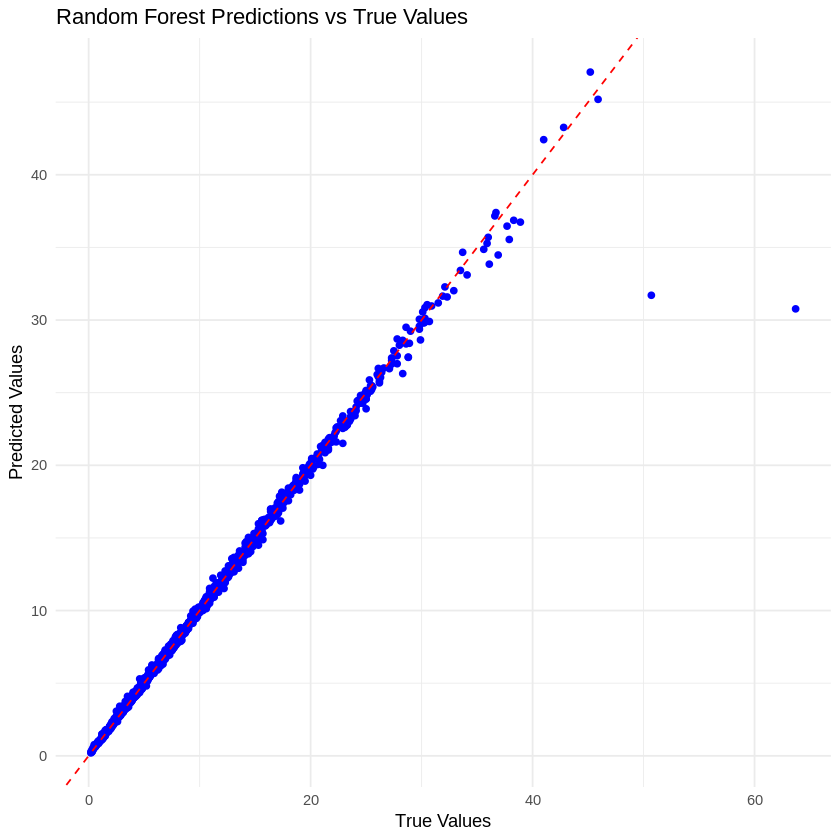

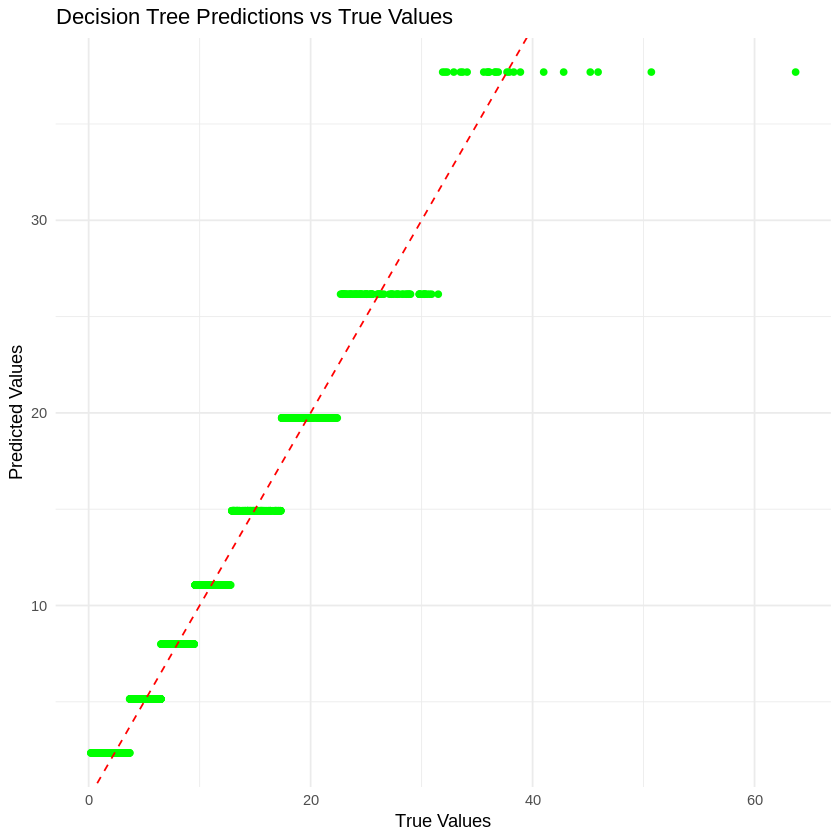

`geom_smooth()` using formula = 'y ~ x'


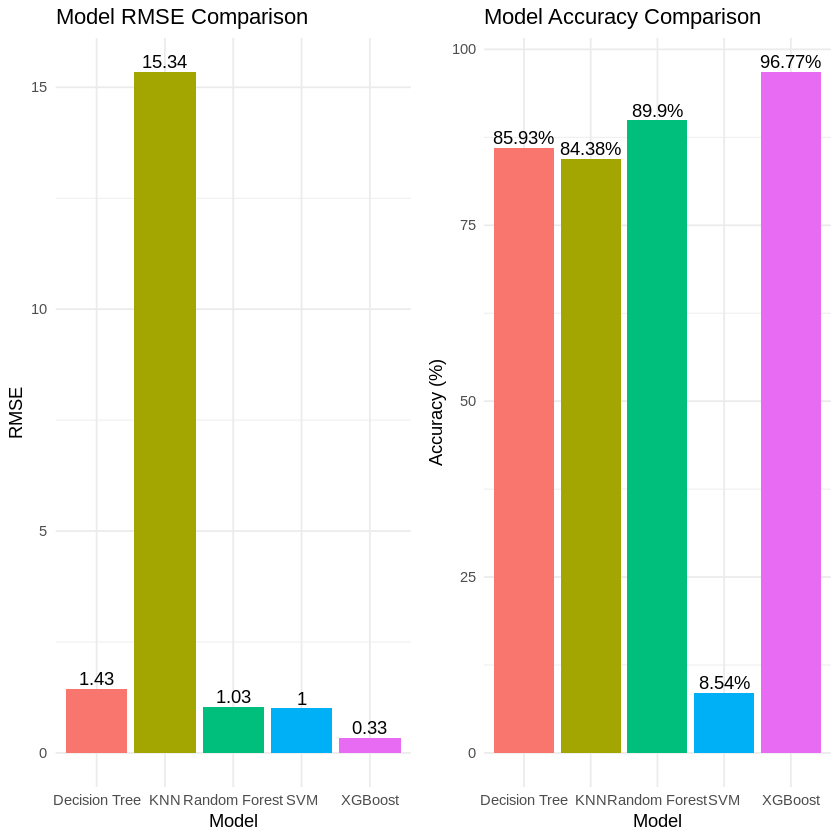

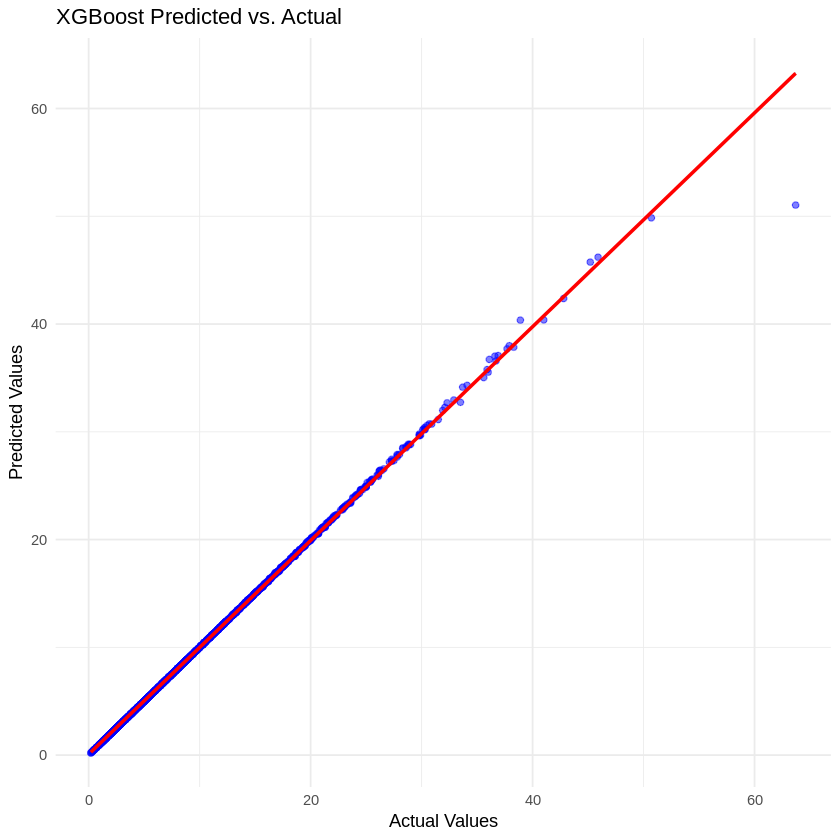

In [ ]:

# ---- Graphical Visual Representation ----
# Scatter plot for Random Forest predictions
ggplot(data.frame(True = testData$C6H6.GT., Predicted = rf_pred), aes(x = True, y = Predicted)) +
  geom_point(color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  ggtitle("Random Forest Predictions vs True Values") +
  xlab("True Values") +
  ylab("Predicted Values") +
  theme_minimal()

# Scatter plot for Decision Tree predictions
ggplot(data.frame(True = testData$C6H6.GT., Predicted = dt_pred), aes(x = True, y = Predicted)) +
  geom_point(color = "green") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  ggtitle("Decision Tree Predictions vs True Values") +
  xlab("True Values") +
  ylab("Predicted Values") +
  theme_minimal()

# Create a dataframe for RMSE and Accuracy comparison
model_results <- data.frame(
  Model = c("Random Forest", "Decision Tree", "KNN", "SVM", "XGBoost"),
  RMSE = c(rf_results$rmse, dt_results$rmse, knn_rmse, svm_rmse, xgb_rmse),
  Accuracy = c(rf_results$accuracy, dt_results$accuracy, knn_accuracy, svm_accuracy, xgb_accuracy)
)

# Plot RMSE for models
rmse_plot <- ggplot(model_results, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  ggtitle("Model RMSE Comparison") +
  xlab("Model") +
  ylab("RMSE") +
  theme(legend.position = "none") +
  geom_text(aes(label = round(RMSE, 2)), vjust = -0.3)

# Plot Accuracy for models
accuracy_plot <- ggplot(model_results, aes(x = Model, y = Accuracy, fill = Model)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  ggtitle("Model Accuracy Comparison") +
  xlab("Model") +
  ylab("Accuracy (%)") +
  theme(legend.position = "none") +
  geom_text(aes(label = paste0(round(Accuracy, 2), "%")), vjust = -0.3)

# Combine RMSE and Accuracy plots
ggarrange(rmse_plot, accuracy_plot, ncol = 2, nrow = 1)

# Scatter Plot of Predicted vs. Actual for XGBoost
xgb_scatter <- ggplot(data.frame(Actual = testData$C6H6.GT., Predicted = xgb_pred), aes(x = Actual, y = Predicted)) +
  geom_point(color = "blue", alpha = 0.5) +
  geom_smooth(method = "lm", col = "red") +
  theme_minimal() +
  ggtitle("XGBoost Predicted vs. Actual") +
  xlab("Actual Values") +
  ylab("Predicted Values")

# Display scatter plot
print(xgb_scatter)

#--- visualization end ------